Editor | Date | Comment
--- | --- | ---
Alireza Ranjbar | 20.10.2018 | Initial version

In [1]:
import sys
import numpy as np
import pandas as pd
import os
import ast
import time
import matplotlib.pyplot as plt
from importlib import reload
import multiprocessing as mp
from multiprocessing import Pool
from functools import partial

# For calculating frequent patterns:
from mlxtend.frequent_patterns import apriori
# The original(serial computing) version of the association_rules learning:
from mlxtend.frequent_patterns import association_rules
# the modified version of the association_rules module source code from mlxtend for compatibility to be 
# used with multiprocessing.pool:
import MP_association_rules

[A brief explanation about multiprocessing.pool](https://www.ellicium.com/python-multiprocessing-pool-process/)

In [3]:
location=r'\\xxxxx'
os.chdir(location)

# for apriori function (run_assoc_rules_learning) :
train_data = pd.read_csv("xxx.csv", delimiter=';')
report_filter='xxxx'
filter_value='xxxx'
sortby='support'
Filtered_Data = train_data[train_data[report_filter]==filter_value] 

freqent_patterns = apriori(Filtered_Data.iloc[:,5:],
                           min_support=0.5,
                           use_colnames=True,
                           max_len=4)

c:\users\dearanj2\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3018: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [24]:
def make_subsets(main_set_df, n_subset):
    """
    splits the input DataFrame into a list of n_subset DataFrame
    """
    subset_size = int(len(main_set_df)/n_subset)
    list_of_subsets = []
    for i in range(n_subset-1):   
        list_of_subsets.append(main_set_df[(i)*subset_size:(i+1)*subset_size])
    list_of_subsets.append(main_set_df[(i+1)*subset_size:])
    return list_of_subsets

In [38]:
def parallel_association_rules(freqent_patterns,
                               n_parallel_branch=mp.cpu_count(),
                               metric="confidence",
                               min_threshold=0.7):
    
    list_of_subsets = make_subsets(main_set_df=freqent_patterns,
                                   n_subset=n_parallel_branch)
    with mp.Pool(processes = n_parallel_branch) as pool:
        results = pool.map(partial
                             (
                                 MP_association_rules.association_rules_MP,
                                 main_set=freqent_patterns,
                                 metric=metric,
                                 min_threshold=min_threshold,
                                 support_only=False),
                                 list_of_subsets
                             ) 
        pool.terminate
    pool.close(); pool.join()
    Final_MP_results = results[0]
    for i in np.arange(1,len(results)):
        Final_MP_results = pd.concat([Final_MP_results,results[i]],ignore_index=True)   
    # returns the equivalent result of the mlxtend association_rules module but computed in parallel
    return Final_MP_results

### Test

In [40]:
parallel_results = parallel_association_rules(freqent_patterns, n_parallel_branch=2, metric="confidence",
                                             min_threshold=0.7)

serrial_results = association_rules(freqent_patterns, metric="confidence", min_threshold=0.7)
serrial_results['antecedents'] = serrial_results['antecedents'].apply(lambda x: list(x))
serrial_results['consequents'] = serrial_results['consequents'].apply(lambda x: list(x))

### Verifying equality of the parallel version out put and that of serial version

In [80]:
# conversion of lists to set, since their order does not matter
serrial_results['antecedents'] = serrial_results['antecedents'].apply(lambda x: set(x))
serrial_results['consequents'] = serrial_results['consequents'].apply(lambda x: set(x))
parallel_results['antecedents'] = parallel_results['antecedents'].apply(lambda x: set(x))
parallel_results['consequents'] = parallel_results['consequents'].apply(lambda x: set(x))

In [79]:
# making sure the lenght of both dataframes are the same
# and all the row in one is found and unique in the other

assert len(parallel_results)==len(serrial_results)
for index, row in parallel_results.iterrows(): 
    matched_rule = serrial_results[serrial_results==row].dropna()
    if len(matched_rule) != 1:
        print('row with index '+ str(index)+ ' in parallel_results does match with any row in serrial results')
        break

# Comparison of the speeds

In [47]:
report_filter='xxxx'
filter_value='xxxx'
sortby='support'


Filtered_Data=train_data[train_data[report_filter]==filter_value]   
MP_times=[]
mlx_times=[]
apriori_length=[]
output_length=[]
for minsup in np.flip(np.arange(0.08,0.5,0.01)):
    
    freqent_patterns = apriori(Filtered_Data.iloc[:,5:],
                                                       min_support=minsup,
                                                       use_colnames=True,
                                                       max_len=None)



    t=time.time() 
    Final_MP_results = Parallel_association_rules(
                                                   freqent_patterns,
                                                   n_parallel_branch=mp.cpu_count(),
                                                   metric="confidence",
                                                   min_threshold=0.7,
                                                   sortby='conviction'
                                                  )

    MP_times.append(time.time()-t)
    #print('Parallel computation took: '+str(time.time()-t)+ ' seconds')


    t=time.time()
    assoc_rules = association_rules(freqent_patterns,
                                   metric="confidence",
                                   min_threshold=0.7)

    assoc_rules['antecedents'] = assoc_rules['antecedents'].apply(lambda x: list(x))
    assoc_rules['consequents'] = assoc_rules['consequents'].apply(lambda x: list(x))
    mlxtend_result=assoc_rules.sort_values(by=['conviction'] ,ascending=False)
    mlxtend_result.index=range(len(mlxtend_result))
    mlx_times.append(time.time()-t)


    
    apriori_length.append(len(freqent_patterns))
    output_length.append(len(assoc_rules))
    #print('Serrial computation took: '+str(time.time()-t)+ ' seconds')
    print('%.2f' %minsup+':'+str(len(freqent_patterns))+' ____ '+str(len(assoc_rules))+':'+str(len(Final_MP_results)))

0.49:25 ____ 90:90
0.48:31 ____ 116:116
0.47:32 ____ 116:116
0.46:34 ____ 118:118
0.45:35 ____ 118:118
0.44:50 ____ 210:210
0.43:52 ____ 215:215
0.42:58 ____ 265:265
0.41:87 ____ 420:420
0.40:123 ____ 879:879
0.39:159 ____ 1833:1833
0.38:162 ____ 1840:1840
0.37:187 ____ 2099:2099
0.36:219 ____ 2596:2596
0.35:299 ____ 5370:5370
0.34:375 ____ 6575:6575
0.33:426 ____ 7587:7587
0.32:508 ____ 8825:8825
0.31:951 ____ 29970:29970
0.30:989 ____ 30182:30182
0.29:1183 ____ 34515:34515
0.28:1199 ____ 34580:34580
0.27:1375 ____ 39306:39306
0.26:1601 ____ 59156:59156
0.25:1710 ____ 61041:61041
0.24:2497 ____ 135928:135928
0.23:2729 ____ 139807:139807
0.22:2874 ____ 142295:142295
0.21:3217 ____ 157157:157157
0.20:3823 ____ 172664:172664
0.19:5887 ____ 325718:325718
0.18:5928 ____ 326209:326209
0.17:6108 ____ 329858:329858
0.16:8316 ____ 445863:445863
0.15:17503 ____ 1766892:1766892
0.14:40995 ____ 7058577:7058577
0.13:59496 ____ 15686665:15686665
0.12:72745 ____ 19389664:19389664
0.11:76110 ____ 195

KeyboardInterrupt: 

The below plots show the computation time of the parallel and original serrial implementation of the mlxtend association rule function. As shown, until ~3500 input number of frequent patterns(equvalent to ~170,000 generated output rules), the parallel implementation takes longer time to finish. Yet, for larger number of frequent patterns as input and more number of rules to be generated, the parallel implementation takes over and finish computation faster.

Text(0, 0.5, 'Computation time')

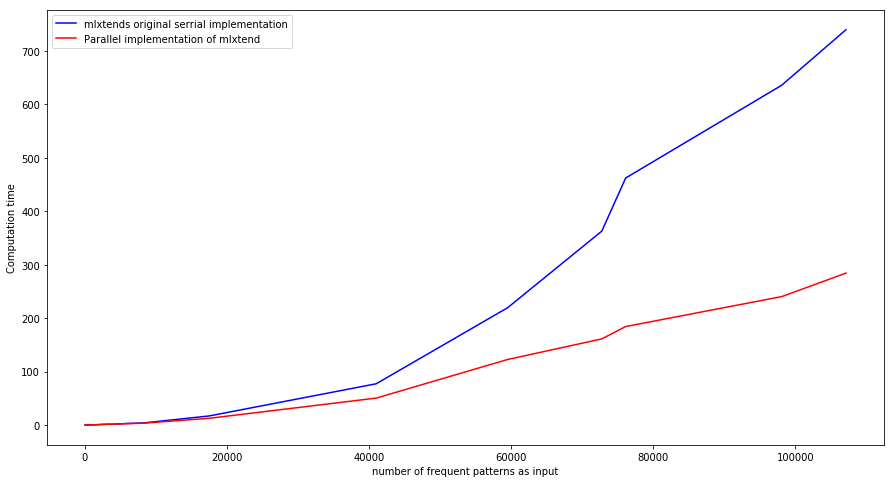

In [54]:
plt.figure(figsize=[15,8])
plt.plot(apriori_length,mlx_times,label='mlxtends original serrial implementation',color='blue')
plt.plot(apriori_length,MP_times[:41],label='Parallel implementation of mlxtend',color='red')
plt.legend()
plt.xlabel('number of frequent patterns as input')
plt.ylabel('Computation time')

Text(0, 0.5, 'Computation time')

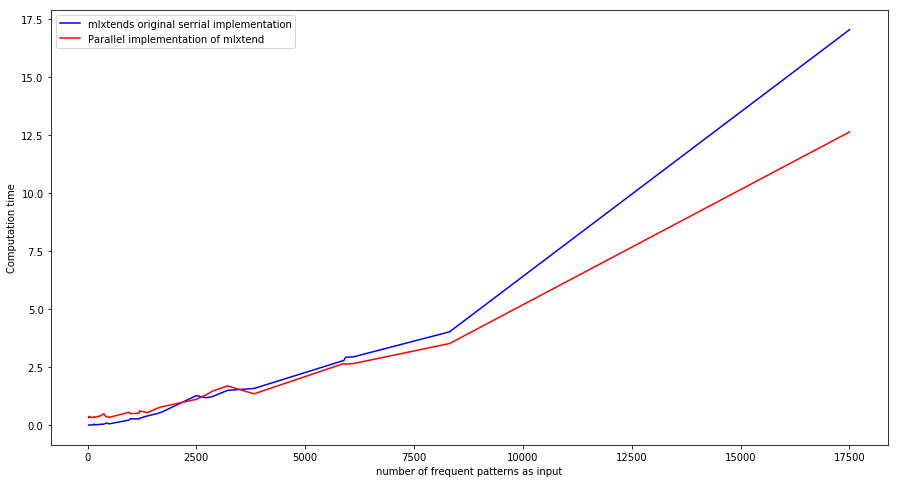

In [49]:
plt.figure(figsize=[15,8])
plt.plot(apriori_length[:35],mlx_times[:35],label='mlxtends original serrial implementation',color='blue')
plt.plot(apriori_length[:35],MP_times[:35],label='Parallel implementation of mlxtend',color='red')
plt.legend()
plt.xlabel('number of frequent patterns as input')
plt.ylabel('Computation time')

##### Checking if the speed and the number of association rules to be made corrolate with each other

In [21]:
report_filter = 'xxx'
filter_value ='xx'
sortby = 'xx'


Filtered_Data = train_data[train_data[report_filter]==filter_value]   
freqent_patterns = apriori(Filtered_Data.iloc[:,5:],
                           min_support=0.15,
                           use_colnames=True,
                           max_len=None)
MP1_times=[]
Final_MP_results1_length = []
for conf in np.flip(np.arange(0,1,0.005)):
    
    t=time.time() 
    Final_MP_results1 = Parallel_association_rules(
                                                   freqent_patterns,
                                                   n_parallel_branch=mp.cpu_count(),
                                                   metric="confidence",
                                                   min_threshold=conf,
                                                   sortby='conviction'
                                                  )
    MP1_times.append(time.time()-t)

    
    Final_MP_results1_length.append(len(Final_MP_results1))
    
    #print('Serrial computation took: '+str(time.time()-t)+ ' seconds')
    print('%.2f' %conf+':'+str(len(Final_MP_results1))+':'+str(time.time()-t))

0.99:542972:6.398490905761719
0.99:714672:6.780039072036743
0.98:732904:7.056840419769287
0.98:775507:6.790558576583862
0.97:786092:6.856907606124878
0.97:810467:6.5707316398620605
0.96:854040:7.656589031219482
0.96:989446:8.31772756576538
0.96:1076964:8.364510297775269
0.95:1098713:8.627721786499023
0.95:1120473:9.2838454246521
0.94:1124151:9.209021091461182
0.94:1127479:9.418996572494507
0.93:1131308:8.709320783615112
0.93:1134730:8.84718370437622
0.92:1136195:8.784182786941528
0.92:1137332:7.88883638381958
0.91:1139053:8.766555070877075
0.91:1140157:8.87088418006897
0.90:1143614:8.95430064201355
0.90:1147013:8.44754672050476
0.89:1152106:9.318695783615112
0.89:1155569:9.156166791915894
0.88:1158132:9.575575113296509
0.88:1161543:9.290791034698486
0.87:1164022:9.498062133789062
0.86:1169386:9.189136028289795
0.86:1171950:9.020557165145874
0.85:1172710:8.212997674942017
0.85:1174638:8.27147364616394
0.84:1178686:8.823163509368896
0.84:1181188:9.412880659103394
0.83:1182450:9.719444513

Text(0, 0.5, 'Computation time (minutes) \n Number of rules/10^7')

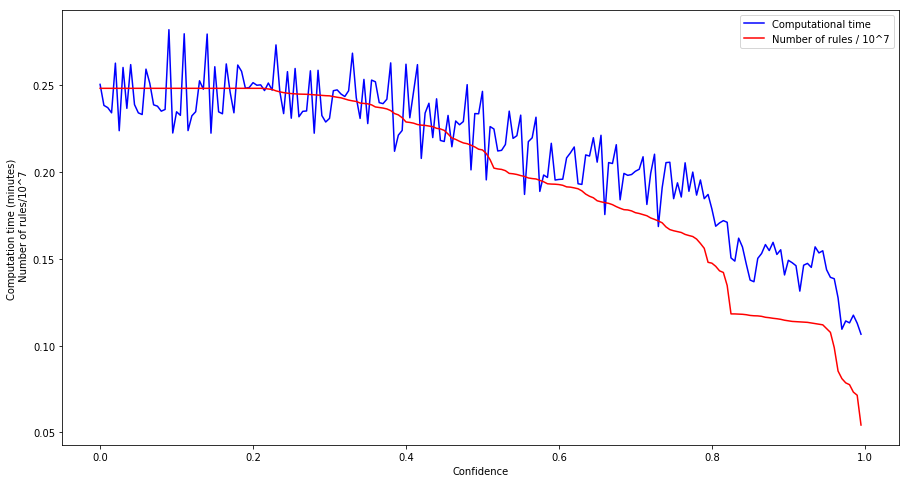

In [43]:
plt.figure(figsize=[15,8])

plt.plot(np.flip(np.arange(0,1,0.005)),[x/60 for x in MP1_times],label='Computational time',color='blue')
plt.plot(np.flip(np.arange(0,1,0.005)),[x/10000000 for x in Final_MP_results1_length],label='Number of rules / 10^7',color='red')
plt.legend()
plt.xlabel('Confidence')
plt.ylabel('Computation time (minutes) \n Number of rules/10^7')